Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [2]:
from random import choices
import random
import lab9_lib
import tqdm
import numpy as np
import time
import scipy
import os

from scipy import stats
from copy import deepcopy
from matplotlib import pyplot as plt
from collections import namedtuple
TERMINATION_SOUND = True

if TERMINATION_SOUND:
    
    import pygame 
    pygame.mixer.init()
    sound_file ="KSBGCBV-happy-fanfare.mp3" 
    sound = pygame.mixer.Sound(sound_file)
    
    # Play the sound
    sound.play() 
    
    # Wait for the sound to finish playing 
    pygame.time.wait(int(sound.get_length() * 1000)) 

from tqdm import tqdm

pygame 2.5.2 (SDL 2.28.3, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [157]:
PROBLEM_SIZE=1000

NUM_GENERATIONS = 10000
EPOCH_DURATION = 10

POPULATION_SIZE = 1000
OFFSPRING_SIZE = 10

MUTATION_PROB = 0.3
#STRONG_MUTATION_PROB = 0.1
#INFORMED_MUTATION_PROB = 0.0
XOVER_PROB = 0.7

SELF_UPDATE=True
MIGRANTS=True
MIGRATION_WAIT = 100
N_ISLANDS = 4
NUM_MIGRANTS = 10
COLORS = ['red','green','blue','black','yellow','purple']





In [145]:


MUT_STRENGTH = 1

def tournament(population, tournament_size=2):
    
    if isinstance(tournament_size,float): #usually instance of int -> skip
        small_size=int(tournament_size)
        big_size=small_size+1
        p_small = tournament_size-float(small_size)
        tournament_size = np.random.choice([small_size,big_size],p=[p_small,1-p_small])
   
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def toggle_mutation(g): #violate the rule of small changes but useful to start
    points = [random.choice([pos for pos in range(0,PROBLEM_SIZE)]) for _ in range(MUT_STRENGTH)]
    child = deepcopy(g)
    for point in points:
        child[point] = 1 - child[point] 
    return child

#classical x_over
#NOT USED
def one_cut_cross_over(g1, g2):
    cut = random.randint(0, PROBLEM_SIZE)
    return g1[:cut] + g2[cut:]

#NOT USED
def two_cut_cross_over(g1, g2):
    cut1 = random.randint(0, PROBLEM_SIZE)
    cut2 = random.randint(0, PROBLEM_SIZE)
    if cut2 < cut1:
        cut1,cut2 = cut2, cut1
    if random.random() < 0.5:
        return g1[:cut1] + g2[cut1:cut2] + g1[cut2:]
    else:
        return g2[:cut1] + g1[cut1:cut2] + g2[cut2:]

def uniform_cross_over(g1, g2):
    keep = choices([0,1],k=PROBLEM_SIZE)
    child = []
    for i,swap in enumerate(keep):
        if swap == 0:
            child.append(g1[i])
        else:
            child.append(g2[i])
    return child

#NOT USED
def uniform_two_cut_cross_over(p1,p2):
    if random.random()<0.2:
        return two_cut_cross_over(p1,p2)
    else:
        return uniform_cross_over(p1,p2)
    
#NOT USED
def voting_cross_over(g1, g2, g3):
    child = []
    for i in range(len(g1)):
        vote = g1[i]+g2[i]+g3[i]
        if vote>=2:
            child.append(1)
        else:
            child.append(0)
    
    return child

#permutation mutation

#NOT USED
def scramble_mutation(g):

    child = deepcopy(g)
    for i in range(MUT_STRENGTH):
        l1 = random.randint(0,len(g)-1)
        l2 = random.randint(0,len(g)-1)
        child[l1],child[l2]=child[l2],child[l1]

    return child

def insert_mutation(g,strength=MUT_STRENGTH): #can cost a lot

    child = deepcopy(g)
    for i in range(strength):
        l1 = random.randint(0,len(g)-2)
        l2 = random.randint(1,len(g)-1)
        if l1 > l2:
            l1,l2=l2,l1
        
        if l2 < len(g)-1:
            child = child[:l1] + [child[l2]] + child[l1:l2] + child[l2+1:]
        else:
            child = child[:l1] + [child[l2]] + child[l1:l2]

    return child
   
#NOT USED
LEN_INV_THRESHOLD = 5
def inversion_mutation(g): #strong mutation

    child = deepcopy(g)
    for i in range(MUT_STRENGTH):
        l1 = random.randint(0,len(g)-2)
        l2 = random.randint(1,len(g)-1)
        if l1 > l2:
            l1,l2=l2,l1
        while( abs(l1-l2) > LEN_INV_THRESHOLD):
            l1 = random.randint(0,len(g)-2)
            l2 = random.randint(1,len(g)-1)
            if l1 > l2:
                l1,l2=l2,l1
        
        
        new_child = child[0:l1]
        new_child += [child[i] for i in range (l2-1,l1-1,-1)]
        new_child += child[l2:]
    
    return child
        

def toggle_insert_mutation(g):
   
    if random.random() < 0.4:
        return toggle_mutation(g)
    else:
        return insert_mutation(g)
    
#permutation crossover

#NOT USED
def s1(sub_seq1,sub_seq2):
    return -sum([(sub_seq1[i]+sub_seq2[i])%2 for i in range(len(sub_seq1))])
#NOT USED
def s2(sub_seq1,sub_seq2):
    return -abs(sum(sub_seq1)-sum(sub_seq2))
#NOT USED
def s3(sub_seq1,sub_seq2):
    int_seq1 = sum([sub_seq1[i]*2**i for i in range(len(sub_seq1))])
    int_seq2 = sum([sub_seq2[i]*2**i for i in range(len(sub_seq2))])
    return -abs(int_seq1-int_seq2)

similarity = s1
#NOT USED
def permutation_crossover(p1,p2): 
    #p1 p2 are divided into 50 blocks
    #than a similarity is computed between each couple of block
    simV = []
    for i in range(50):
        for j in range(50):
            sij = similarity(p1[i*20:(i+1)*20],p2[j*20:(j+1)*20])
            simV.append((sij,i,j))
    
    simV.sort(key = lambda x: x[0])
    mapping_g1=[]
    mapping_g2=[]
    for _ in range(50):
        mapping_g1.append(0)
        mapping_g2.append(0)
    
    found=1
    for pair in simV:
        (_,i,j) = pair
        if (mapping_g1[i]==0) and (mapping_g2[j]==0):
            mapping_g1[i]=found
            mapping_g2[i]=found
            found+=1
        if found == len(mapping_g1):
            break # mapping is complete
    
#------

#NOT USED
def informed_toggle_mutation(g, unreachable_loci):
    points = [random.choice(unreachable_loci) for _ in range(MUT_STRENGTH)]
    child = deepcopy(g)
    for point in points:
        child[point] = 1 - child[point] 
    return child

mutation = toggle_insert_mutation
cross_over = uniform_cross_over
#informed_mutation=informed_toggle_mutation

initial population:10


Generation:   0%|                                                  | 0/100 [00:00<?]

Generation:  43%|█████████████████████▌                            | 43/100 [02:17<02:42]

ok
ok
ok


Generation:  43%|█████████████████████▌                            | 43/100 [02:19<03:04]


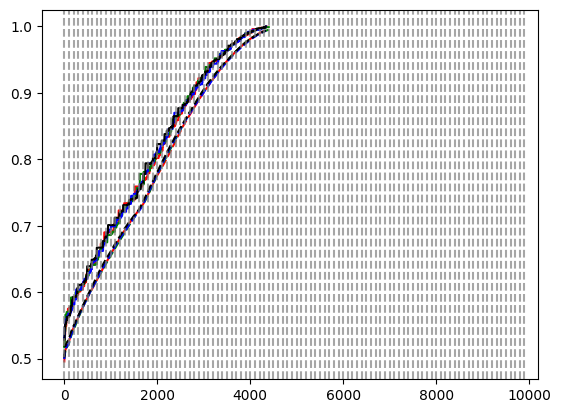

best fitness run size 1: 1.0
fitness calls:174310

initial population:10


Generation: 100%|██████████████████████████████████████████████████| 100/100 [05:57<00:00]


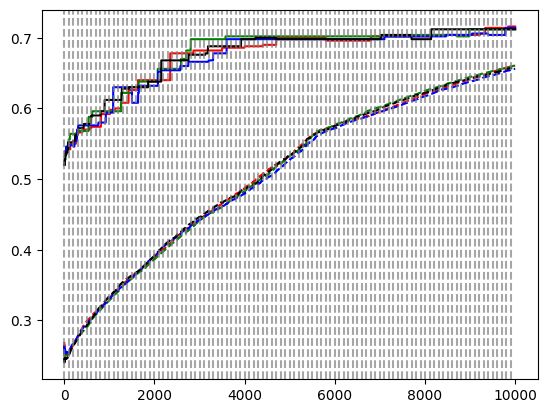

best fitness run size 2: 0.716
fitness calls:400010

initial population:10


Generation: 100%|██████████████████████████████████████████████████| 100/100 [05:48<00:00]


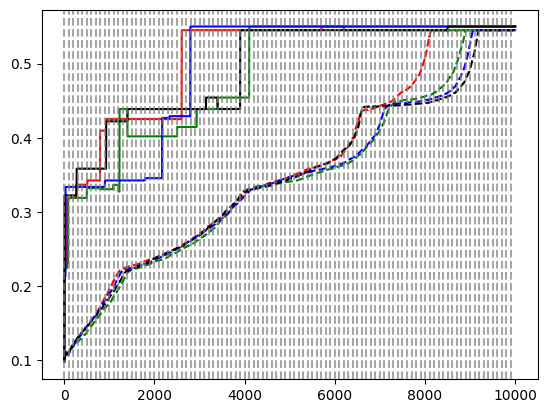

best fitness run size 5: 0.55
fitness calls:400010

initial population:10


Generation: 100%|██████████████████████████████████████████████████| 100/100 [05:33<00:00]


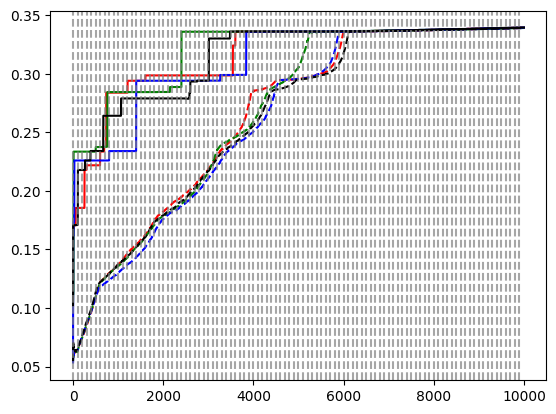

best fitness run size 10: 0.339668
fitness calls:400010

[1.0, 0.716, 0.55, 0.339668]


In [159]:
#FASTER

Individual = namedtuple("Individual", ["genome", "fitness"])

#p_gen_op = np.array([STRONG_MUTATION_PROB,MUTATION_PROB,XOVER_PROB,1-(STRONG_MUTATION_PROB+MUTATION_PROB+XOVER_PROB)])
#p_gen_op = np.array([STRONG_MUTATION_PROB,MUTATION_PROB,XOVER_PROB])
#p_gen_op = np.array([MUTATION_PROB,XOVER_PROB,INFORMED_MUTATION_PROB])
p_gen_op = np.array([MUTATION_PROB,XOVER_PROB])

custom_bar_format = "{l_bar}{bar:50}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"

result = []

for run_size in [1,2,5,10]: #originally used to run multiple test on same size

    fitness = lab9_lib.make_problem(run_size)
    
    if MIGRANTS:
        populationV = []
        population = []
        for n in range(10): #don't change initial population
            ind = choices([0, 1], k=PROBLEM_SIZE)
            population.append(Individual(ind, fitness(ind)))

        xV=[]
        yV=[]
        myV=[]
        for i in range(N_ISLANDS):
            populationV.append(deepcopy(population))
            xV.append([])
            yV.append([])
            myV.append([])
        n_improvedV = [0 for _ in range(N_ISLANDS)]
        #t_sizeV = [1 for _ in range(N_ISLANDS)]
        t_size = 1
    else:
        population = []
        for n in range(10): #don't change initial population
            ind = choices([0, 1], k=PROBLEM_SIZE)
            population.append(Individual(ind, fitness(ind)))
        
        x=[] #generation
        y=[] #top_fitness
        n_improved=0

    print(f"initial population:{fitness.calls}")
   
    progress_bar = tqdm(range(NUM_GENERATIONS//MIGRATION_WAIT),dynamic_ncols=True,desc="Generation",colour="green",total=NUM_GENERATIONS//MIGRATION_WAIT,mininterval=0.5,bar_format=custom_bar_format,ncols=100)

    for g in progress_bar:
        
        if MIGRANTS:

            #migration avoided at start and done before the last mutation
            if(len(populationV[0])==POPULATION_SIZE): #at start population size = 10 -> need first to grow
                for i in range(0,N_ISLANDS):
                    for j in range(i+1,N_ISLANDS):
                        migrants_from_i = random.sample([n for n in range(POPULATION_SIZE)], k = NUM_MIGRANTS)
                        migrants_from_j = random.sample([n for n in range(POPULATION_SIZE)], k = NUM_MIGRANTS)
                            
                        for m in range(NUM_MIGRANTS):
                            populationV[i][migrants_from_i[m]],populationV[j][migrants_from_j[m]]=populationV[j][migrants_from_j[m]],populationV[i][migrants_from_i[m]]

            for island_number in range(N_ISLANDS):
                
                population = populationV[island_number]

                for g_island in range(MIGRATION_WAIT):
                    
                    offspring = []
        
                    for i in range(OFFSPRING_SIZE):
                        action = np.random.choice([0,1],p=p_gen_op) # keep it 0.3, 0.7 -> ideal

                        if action == 0:
                            p = tournament(population,t_size)
                            o = mutation(p.genome)
                        elif action == 1:
                            p1 = tournament(population,t_size)
                            p2 = tournament(population,t_size)
                            o = cross_over(p1.genome, p2.genome)

                        f = fitness(o)
                        
                        offspring.append(Individual(o, f))
                    
                    # tweak t_size -> with problem 5 necessity to slow down convergency by a lot to preserve diversity
                    if SELF_UPDATE: # originally check 1 5 rule
                        if g_island%EPOCH_DURATION == 0:
                            t_size += 1.5/(NUM_GENERATIONS//EPOCH_DURATION)
                            t_size = min(2,t_size)
                        
                    
                    population += offspring
                    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE] 

                    xV[island_number].append(g*MIGRATION_WAIT+g_island)
                    yV[island_number].append(population[0].fitness)
                    myV[island_number].append(sum([population[i].fitness for i in range(len(population))])/len(population))

                    if(population[0].fitness == 1):
                        print("ok")
                        break
                        
                populationV[island_number]=deepcopy(population)
            
            if(1.0 in [populationV[i][0].fitness for i in range(N_ISLANDS)]):
                break 
    

    if MIGRANTS:
        for island_number in range(N_ISLANDS):
            plt.plot(xV[island_number],yV[island_number],color=COLORS[island_number])
            plt.plot(xV[island_number],myV[island_number],color=COLORS[island_number],linestyle='--')
        [plt.axvline(x,linestyle='--', color='gray', alpha=0.7) for x in range(0,NUM_GENERATIONS,MIGRATION_WAIT)]

        plt.show()
        best=max([populationV[island_number][0].fitness for island_number in range(N_ISLANDS)])
        print(f"best fitness run size {run_size}: {best}")
        result.append(best)

    print(f"fitness calls:{fitness.calls}\n")

    if TERMINATION_SOUND:
        # Play the sound
        sound.play()
        # Wait for the sound to finish playing 
        pygame.time.wait(int(sound.get_length() * 1000)) 

print(result)

# DON'T REVIEW (TRY AND ERROR REPORT) until next NOTE

#--> use TOGGLE,UNIFORM for problem 1

#--> SCRAMBLE 0.488, INSERT 0.544, INVERSION 0.256 limit len 10 0.2806, limit len 5 0.25, limit len 4 0.26 -> not_working

#diversity promotion

#tried fitness hole 0.966, 0.972, 0.966, 0.864, 0.756
#try also adding gaussian noise on fitness, sigma mutated like in SA -> can further explore, idea from Filippo Greco telegram public message
#tried w/o fitness hole 0.984,0.986,0.992, 0.982, 0.796, 0.992 --> better

#tried different tournament size for different improvement rate -> 10000 generations, 10 offspring, 100 population 
#1.7 for < 1/5 --> 0.644, 0.992, 0.948, 0.98, 0.92
#1.5 for < 1/5 --> 0.984, 0.594, 0.97, 0.998, 0.99
#2.0 for < 1/5 --> 0.928, 0.598, 0.972, 0.822, 0.966

# -> maybe is useful to lower t_size -> 1.7 produce good results
#instead of 1.7 / 2.0
#1.7 / 1.9 --> 0.986, 0.638, 0.944, 0.984, 0.98
#1.6 / 2.1 --> 0.982, 0.762, 0.984, 0.982, 0.988 --> seems the best tried option

#tried migrants
#PROBLEM 2
#1000: 0.592, 0.638..., 10000: 0.984 -> single island 
#1000: 0.644, 0.612, 0.612, 0.592 -> multi island alone
#5 migrants every 100 generations
#1000: 0.654, 0.662, 0.652, 0.646
#5 migrants every 50 generations
#1000: 0.66, 0.662, 0.662, 0.664 --> best for 1000 generations
#10 migrants every 50 generations
#1000: 0.652, 0.656, 0.65, 0.654
#10 migrants every 100 generations
#1000: 0.644, 0.644, 0.644, 0.646
#5 migrants every 20 generations
#1000: 0.642, 0.634, 0.642, 0.642
#10  migrants every 100 generations
#10000: 0.968, 0.968, 0.97, 0.972
#5 migrants every 500 generations
#10000: 0.966, 0.964, 0.962, 0.962
#5 migrants every 250 generations + shuffle order
#10000: 0.916, 0.918, 0.916, 0.914
#5 migrants every 500 generations + shuffle order
#10000: 0.944, 0.94, 0.942, 0.938
#offspring size = 5
#10 migrants every 500 generations
#10000: 0.9, 0.894, 0.898, 0.892
#5 migrants every 500 generations
#10000: 0.86, 0.86, 0.862, 0.858
#offspring size = 10
#15 migrants every 500 generations
#10000: 0.944, 0.944, 0.944, 0.944 --> no good (15 is too much)

#PROBLEM 3 ? typo
#5 migrants every 50 generations
#100000: 0.6, 0.6, 0.6, 0.6 
#10000: 0.702, 0.699, 0.699, 0.696

#5 migrants every 50 generations migrants + w o informed_mutation
#1000: 0.558, 0.555, 0.558, 0.555 / 0.537, 0.543, 0.543, 0.537 / 0.588, 0.582, 0.585, 0.582 / 0.555, 0.555, 0.552, 0.552 / 0.558, 0.558, 0.558, 0.558
#5 migrants every 50 generations migrants + only informed_mutation
#1000: 0.516, 0.516, 0.516, 0.522 / 0.531, 0.522, 0.522, 0.522 / 0.525, 0.525, 0.525, 0.525 / 0.534, 0.534, 0.534, 0.534 / 0.579, 0.579, 0.579, 0.579
#runned ks test -> no result, since this strategy is more expensive use w/o infromed mutation

#PROBLEM 5
#passed to 5 consecutive run, print only best fitness
#gen: 1000, pop: 100, offspring: 10, migrants: 5, migration wait: 50, insert_toggle_mutation
# 0.485, 0.505, 0.426, 0.438, 0.424
#gen: 1000, pop: 100, offspring: 10, migrants: 5, migration wait: 50, insert_reverse_toggle_mutation
# 0.5, 0.438, 0.52, 0.342, 0.327 -> convergence speed need to slow down
#gen: 1000, pop: 100, offspring: 10, migrants: 5, migration wait: 100, epoch time: 10 , insert_toggle_mutation
# 0.52, 0.52, 0.58, 0.424, 0.505, 0.437, 0.55, 0.43, 0.409, 0.42, 0.429, 0.432, 0.424, 0.428, 0.53 -> good, use this but lower more selective pressure
#gen: 1000, pop: 100, offspring: 10, migrants: 5, migration wait: 100, epoch time: 10 , insert_toggle_mutation (+,-) 0.05 unified t_size
# 0.575, 0.432, 0.505, 0.437, 0.51 
# reformulated algorithm, no (+,-) 0.05 t_size
# 0.535, 0.402, 0.5, 0.51, 0.45, 0.4, 0.389, 0.41, 0.45, 0.51, 0.41, 0.41, 0.535, 0.426, 0.457 --> ok, same, wrong data (fitness[0] in algorithm 2 doesn't contain same fitness since you swap also at end)
# reformulated algorithm, no (+,-) 0.05 t_sizeV, corrected version
# 0.445, 0.456, 0.431, 0.434, 0.421, 0.426, 0.412, 0.465, 0.454, 0.413, 0.415, 0.505, 0.515, 0.45, 0.54
# reformulated algorithm, add (+,-) 0.05 t_sizeV, corrected version (SELF_UPDATE=True)
# 0.451, 0.418, 0.54, 0.459, 0.431, 0.426, 0.419, 0.41, 0.535, 0.425, 0.418, 0.52, 0.52, 0.54, 0.417 -> same
# inverted +/-: correct
# 0.432, 0.426, 0.525, 0.413, 0.515, 0.555, 0.417, 0.515, 0.448, 0.439, 0.451, 0.437, 0.430, 0.435, 0.449 -> same
# -> (start with t_size=1)
# 0.4445, 0.409, 0.444, 0.4273, 0.53, 0.4373, 0.32973, 0.4239, 0.4273, 0.56, 0.53, 0.454, 0.356, 0.428, 0.49
# recomputing baseline

# 10000 gen same config
# 0.42, 0.44, 0.345, 0.452, 0.436, 0.515, 0.452, 0.424, 0.436, 0.448, 0.416, 0.42, 0.424, 0.339, 0.339
# -> need to slow down convergency by a lot
# + population_size = 1000 + migrants = 25, around 5000 tend to still be a complete copy of fittest
# 5 run around 0.56
# -> still need to slow down convergency -> migration wait: +250 
# 5 run around 0.556 -> no significant improvement
# -> t_size adaptation (+-0.05)
# 0.575, 0.535, 0.535, 0.545, 0.59 -> no improvements in term of mean performance but the fitness/epoch graph is more "smooth" -> good
# -> t_size adaptation (+0.05, -0.1)
# 0.55, 0.57, 0.535, 0.585, 0.54 -> 0.556
# -> slow down migration : -migrants: 10
# 0.565, 0.57, 0.57, 0.565, 0.54
# -> slow down migration : -migrants: 5 -> preserve good distance between islands
# 0.565, 0.6, 0.448, 0.55, 0.46 -> can fail
# -> increase island to 5, slow start (t_sizeV=[1,1,1,1,1])
# 0.54, 0.55, 0.57, 0.525, 0.565, 0.525, 0.57, 0.57, 0.555, 0.54 -> no significant improvement
# -> + migrants: 10, t_size adaptation (+0.05, -0.25) , epoch_duration = 5, slow start, -island: 4
# 0.555, 0.555, 0.535, 0.555, 0.525 -> performance loss
# -> t_size adaptation (+0.05, -0.1), +epoch_duration = 50 
# 0.575, 0.565, 0.575 -> realized that self update was ineffective since implemented wrong
# introduce real self update t_size starting from [1,1,1,1]
# 0.545, 0.565, 0.585, 0.555, 0.58 -> good, USE THIS
# t_size adaptation (only increase in time uniform until 2/3, x1.5)
# 0.59, 0.55, 0.57, 0.56, 0.575 -> can still slow down,                  ############################ BEST RESULT FOR DIMENSION 5 #########################
# t_size adaptation (only increase in time uniform until 2/3, x1) but at every generation
# 0.56, 0.545, 0.545 -> too fast convergence (probably due to every generation update of t_size)
# -> update at epoch
# 0.575, 0.535, 0.56


# NOTE: FINAL TEST on [1,2,5,10] SHOW RESULT PRINTED IN OUTPUT
# NOTE: higher fitness with less fitness call has been found for fitness 1 (around 7000 for 1.0) -> probably can be obtained by setting costant t_size=2 and smaller population
# NOTE: higher fitness with less fitness call has been found for fitness 2 (around 200000 for 0.9, see past commit) -> probably can be obtained by setting costant t_size=2 and smaller population
# NOTE: this results are optimized for fitness 5

In [93]:
print(SELF_UPDATE)
print(POPULATION_SIZE)
print(OFFSPRING_SIZE)
print(MIGRATION_WAIT)

True
100
10
100


In [121]:
#trying to run kolmogorov-smirnov (online) test on all best island 
baseline = [0.445, 0.456, 0.431, 0.434, 0.421, 0.426, 0.412, 0.465, 0.454, 0.413, 0.415, 0.505, 0.515, 0.45, 0.54]
baseline2 = [0.535, 0.4249, 0.441, 0.52, 0.34587, 0.4507, 0.4362, 0.443, 0.45, 0.525, 0.52, 0.515, 0.427, 0.4175, 0.434]

print(sum(baseline)/15)
print(sum(baseline2)/15) # better anyway :)
print(stats.ks_2samp(baseline2,baseline2))
#similarity wrong @ 15 = 0.385 no t_size
#similarity correct @ 15 = 0.678 no t_size
#similarity with and without +- 0.05 t_size @ 15 = 0.678 ? same



0.45213333333333333
0.4619333333333333
KstestResult(statistic=0.4, pvalue=0.18441617684449832, statistic_location=0.424, statistic_sign=-1)
